In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 
from sklearn.metrics import accuracy_score
from scipy.special import expit

df = pd.read_csv('responses.csv', sep=",")

In [12]:
# change NaN number values to the mean
df_imputed = df.fillna(df.mean())
# get categorical features
object_features = list(df.select_dtypes(include=['object']).columns)
# one hot encode categorical features
one_hot_df = pd.concat([pd.get_dummies(df_imputed[col],prefix=col) for col in object_features], axis=1)
# drop object features from imputed dataframe
df_imputed_dropped = df_imputed.drop(object_features, 1)
frames = [df_imputed_dropped, one_hot_df]
# concatenate both frames by columns
df_fixed = pd.concat(frames, axis=1)

In [13]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'Fear of public speaking' in df_fixed:
    y = df_fixed['Fear of public speaking'].values # get the labels we want
    del df_fixed['Fear of public speaking'] # get rid of the class label
    X = df_fixed.values # use everything else to predict!

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(
                         n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [14]:
%%time
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += 2 * self.w_[1:] * self.C
        
        return gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 

# blr = BinaryLogisticRegression(eta=0.1,iterations=500,C=0.001)

# blr.fit(X,y)
# print(blr)

# yhat = blr.predict(X)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 47 µs, sys: 1 µs, total: 48 µs
Wall time: 53.2 µs


In [15]:
%%time
from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X + 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += 2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient
       
# hlr = HessianBinaryLogisticRegression(eta=0.1,iterations=20,C=0.1) # note that we need only a few iterations here

# hlr.fit(X,y)
# yhat = hlr.predict(X)
# print(hlr)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 54 µs, sys: 1 µs, total: 55 µs
Wall time: 59.8 µs


In [16]:
%%time
# for this, we won't perform our own BFGS implementation 
# (it takes a good deal of code and understanding of the algorithm)
# luckily for us, scipy has its own BFGS implementation:
from scipy.optimize import fmin_bfgs
class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2) #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += 2 * w[1:] * C
        return -gradient
    
    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))
            
# bfgslr = BFGSBinaryLogisticRegression(_,2) # note that we need only a few iterations here

# bfgslr.fit(X,y)
# yhat = bfgslr.predict(X)
# print(bfgslr)
# print('Accuracy of: ',accuracy_score(y,yhat+1))

CPU times: user 52 µs, sys: 1 µs, total: 53 µs
Wall time: 57.9 µs


In [17]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            hblr = HessianBinaryLogisticRegression(self.eta,self.iters,self.C)
            hblr.fit(X,y_binary)
            #print(accuracy(y_binary,hblr.predict(X)))
            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row
    



In [18]:
# run logistic regression and vary some parameters
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = MultiClassLogisticRegression(eta=0.1,iterations=10, C=0.0001) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
#     print(X_train)
#     print(y_train)
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat+1)
    conf = mt.confusion_matrix(y_test,y_hat+1)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.237623762376
confusion matrix
 [[10  9  0  5  2  1]
 [10 14  0 18  4  2]
 [ 9 15  0 27 15  4]
 [ 4  4  0 17  5  6]
 [ 1  0  0 10  7  3]
 [ 0  0  0  0  0  0]]


ValueError: Can't handle mix of continuous and multiclass

In [ ]:
%%time
lr = MultiClassLogisticRegression(eta=0.1,iterations=10,C=0.0001)
lr.fit(X,y)
print(lr)

yhat = lr.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat+1))

In [19]:
# linear boundaries visualization from sklearn documentation
from matplotlib import pyplot as plt
import copy
%matplotlib inline

def plot_decision_boundaries(lr,Xin,y,title=''):
    Xb = copy.deepcopy(Xin)
    lr.fit(Xb[:,:2],y) # train only on two features

    h=0.01
    # create a mesh to plot in
    x_min, x_max = Xb[:, 0].min() - 1, Xb[:, 0].max() + 1
    y_min, y_max = Xb[:, 1].min() - 1, Xb[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # get prediction values
    Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.5)

    # Plot also the training points
    plt.scatter(Xb[:, 0], Xb[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Feature')
    plt.ylabel('Fear of Public Speaking')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()


In [20]:
X

array([[ 5.,  3.,  2., ...,  1.,  1.,  0.],
       [ 4.,  4.,  2., ...,  0.,  1.,  0.],
       [ 5.,  5.,  2., ...,  0.,  1.,  0.],
       ..., 
       [ 4.,  3.,  1., ...,  0.,  1.,  0.],
       [ 5.,  3.,  3., ...,  0.,  1.,  0.],
       [ 5.,  5.,  4., ...,  1.,  0.,  1.]])

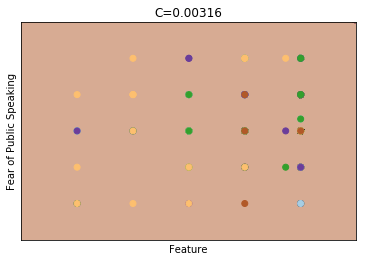

In [21]:
from ipywidgets import widgets as wd

cost_vals = np.logspace(-3,-2,15)
def lr_explor(cost_idx):
    C = cost_vals[cost_idx]
    lr_clf = MultiClassLogisticRegression(eta=0.1,
                                           iterations=2500,
                                           C=C) # get object
    
    plot_decision_boundaries(lr_clf,X,y,title="C=%.5f"%(C))

wd.interact(lr_explor,cost_idx=(0,15,1),__manual=True)

In [23]:
%%time
from sklearn.linear_model import LogisticRegression as SKLogisticRegression

lr_sk = SKLogisticRegression() # all params default
lr_sk.fit(X,y)
# print(np.hstack((lr_sk.intercept_[:,np.newaxis],lr_sk.coef_)))
# yhat = lr_sk.predict(X)
print('Accuracy of: ',accuracy_score(y,yhat))

ValueError: Unknown label type: 'continuous'